This case study will explore the examples of Wassmer and Dragalin (2015). This paper uses closed testing methods to ensure Type I Error control, while adapting the trial to focus patient recruitment on the subpopulations where the treatment performs best.

There are 3 different case studies in the paper: 4.1, 4.2, and 4.3.
4.1 uses binomial outcomes, with a Bonferroni rule, with 2 total subgroups x 2 treatments (T vs C) = 4 parameters. Two analysis times, including the final. This should be improvable.
4.2 uses exponential outcomes, does a log-rank test with Dunnett's test for multiple comparisons, with 2 total subgroups x 2 treatments = with 2 total subgroups x 2 treatments (T vs C) = 4 parameters. Four analysis times, including the final. We expect that this one is essentially tight/hard to improve, because it uses Dunnett, which should be tight
4.3 uses exponential outcomes, and does log-rank tests with the Bonferroni rule, with 4 subgroups x 2 treatments = 8 parameters. This is too much for proof-by-simulation to cover. We could still give a superior power analysis to what was reported in the paper, which fixes many of these parameters and varies the treatment effects.

Of this subset, WE WILL DO: 4.1, and then show that it can also be done under exponential outcomes, in both cases yielding improvements.

If we want to beef it up further we could try to compare against 4.2


In [1]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imprint as ip
import numpy as np
import math
import random
import jax
import jax.numpy as jnp
from scipy.special import expit, logit

First, we will replicate example 4.1
The population breakdown is 54% HRplus, 46% no-HRplus. [Let's assumed blocked sample sizes, for simplicity; and note that this anyway describes how the problem would be approached with post-conditioning]

The null hypotheses here are:
(1) HRplus > 0.34
(2) 0.54 p_HRplus + 0.46 p_HER+ > 0.54 _ 0.34 + 0.46 _ 0.23

A decision will be made after 150 patients. There is no early-stopping, but the trial can either select the HRplus group, or continue to the final analysis. This selection occurs if the estimated effect size of HRplus = p-hat_HRplus - 0.34 > epsilon + p-hat_average - (0.34*.54 + 0.23*0.46)
where epsilon = 10%

If the HER+ group is dropped, then its p-value automatically jumps to 1 and stays there(cannot-reject) but it is still present for the closed test.

The p-values for the closed test are determined by inference on the binomial using the z-approximation with pooling treatment and control:

Z = pi-hat_1 - pi-hat_0 /sqrt(pi-hat-combined _ (1 - pi-hat-combined)_(1/n_1 + 1/n_2))

We will do closed testing on the p-values from these two z-statistics.


In [2]:
# Let's make some sub-methods, to perform the methods given one binomial setting
pcontrol_TNBC = 0.34
ptreat_TNBC = 0.38
pcontrol_HRplus = 0.23
ptreat_HRplus = 0.27

# TODO: effect size is 0.04 so we are in alternative space for both hypotheses.
# null hypo 1: effect size of tnbc = 0
# null hypo 2: effect size of weighted average of tnbc and hrplus = 0
#

# generate hypotheses: for this, we have to do stuff similar to the closedtesting.pynb
# There will be 2 hypotheses, one of which will have to be identified with a nonlinear equation in theta-space
# Let's leave that to Ben, and just focus on executing the design

## Things to improve here:
- subgroup weightings
- constructing null hypothesis boundaries for imprint
- run imprint
- make it fast/jax-ify
- compare against a simple t-test with the same simulation/model.
  

In [8]:
n_first_stage = 150
n_second_stage = 150
frac_tnbc = 0.54
n_TNBC_first_stage_per_arm = int(np.floor((n_first_stage * frac_tnbc) * 0.5))
n_HRplus_first_stage_per_arm = int(np.floor(n_first_stage * (1 - frac_tnbc) * 0.5))
n_TNBC_first_stage_per_arm, n_HRplus_first_stage_per_arm, n_TNBC_first_stage_per_arm * 2 + n_HRplus_first_stage_per_arm * 2

(40, 34, 148)

In [7]:
# We'll repeat this for the second half, which is the same size as the first half
# TODO: 54% TNBC, 46% HR+ (look at the paper) and then equal splits between
# treatment and control within those subgroups.

npatientstotal = 600
npatientsperarm_firststage = 75  # for the first interim analysis

npatientstotal = 300
npatientsperarm_firststage = 37  # for the first interim analysis

def sim(pcontrol_TNBC=0.34, ptreat_TNBC=0.38, pcontrol_HRplus=0.23, ptreat_HRplus=0.27):
    # We now have to make a list of the relevant
    # intersection hypotheses,
    # which are indentified by which subgroups are part of them
    # In this example, there are 2 elementary hypotheses
    hypoTNBC_live = True
    hypofull_live = True
    # There is also the intersection hypothesis:
    # hypo_both_live

    unifsTNBCcontrol = np.random.uniform(size=npatientsperarm_firststage)
    unifsTNBCtreat = np.random.uniform(size=npatientsperarm_firststage)
    unifsHRpluscontrol = np.random.uniform(size=npatientsperarm_firststage)
    unifsHRplustreat = np.random.uniform(size=npatientsperarm_firststage)
    outcomesHRpluscontrol = unifsHRpluscontrol < pcontrol_HRplus
    outcomesHRplustreat = unifsHRplustreat < ptreat_HRplus
    outcomesTNBCcontrol = unifsTNBCcontrol < pcontrol_TNBC
    outcomesTNBCtreat = unifsTNBCtreat < ptreat_TNBC

    # HRplus_pooledaverage = outcomesHRplustreat.mean()/2 + outcomesHRpluscontrol.mean()/2
    # denominatorHRplus = np.sqrt(HRplus_pooledaverage*(1-HRplus_pooledaverage)*(1/npatientsperarm + 1/npatientsperarm))
    # zHRplus_stage1 = (outcomesHRplustreat.mean() - outcomesHRpluscontrol.mean())/denominatorHRplus

    # Note: this could be expressed more simply as a single function if we could nicely combine treatment outcome columns. but whatever...
    TNBC_pooledaverage = outcomesTNBCtreat.mean() / 2 + outcomesTNBCcontrol.mean() / 2
    denominatorTNBC = np.sqrt(
        TNBC_pooledaverage
        * (1 - TNBC_pooledaverage)
        * (1 / npatientsperarm_firststage + 1 / npatientsperarm_firststage)
    )
    zTNBC_stage1 = (
        outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
    ) / denominatorTNBC

    # TODO: account for subgroup pop sizes here (54% TNBC, 46% HR+)
    totally_pooledaverage = (
        outcomesTNBCtreat.mean() / 4
        + outcomesTNBCcontrol.mean() / 4
        + outcomesHRplustreat.mean() / 4
        + outcomesHRpluscontrol.mean() / 4
    )
    denominatortotallypooled = np.sqrt(
        totally_pooledaverage
        * (1 - totally_pooledaverage)
        * (1 / (2 * npatientsperarm_firststage) + 1 / (2 * npatientsperarm_firststage))
    )
    zfull_stage1 = (
        outcomesTNBCtreat.mean() / 2
        + outcomesHRplustreat.mean() / 2
        - outcomesTNBCcontrol.mean() / 2
        - outcomesHRpluscontrol.mean() / 2
    ) / denominatortotallypooled

    # Arm-dropping logic: drop all elementary hypotheses with larger than 0.1 difference in effect size
    tnbc_effect = outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
    hrplus_effect = outcomesHRplustreat.mean() - outcomesHRpluscontrol.mean()
    effectsize_difference = tnbc_effect - hrplus_effect
    # TODO: investigate this dropping logic. Section 3.4
    # TODO: this is wrong and should be compared to the weighted average treatment effects instead of the HRplus treatment effect.
    if effectsize_difference > 0.1:
        hypofull_live = False
    if effectsize_difference < -0.1:
        hypoTNBC_live = False

    # now compute second-stage z-statistics
    if not hypofull_live:  # In this case we drop the HRplus arm
        # TODO: floor? ceiling? round?
        npatientsperarm_secondstage = int(
            (npatientstotal - npatientsperarm_firststage * 4) / 2
        )  # should be 150: we now have only 2 arms
        unifsTNBCcontrol = np.random.uniform(size=npatientsperarm_secondstage)
        unifsTNBCtreat = np.random.uniform(size=npatientsperarm_secondstage)
        unifsHRpluscontrol = np.random.uniform(size=npatientsperarm_secondstage)
        outcomesTNBCcontrol = unifsTNBCcontrol < pcontrol_TNBC
        outcomesTNBCtreat = unifsTNBCtreat < ptreat_TNBC
        TNBC_pooledaverage = (
            outcomesTNBCtreat.mean() / 2 + outcomesTNBCcontrol.mean() / 2
        )
        denominatorTNBC = np.sqrt(
            TNBC_pooledaverage
            * (1 - TNBC_pooledaverage)
            * (1 / npatientsperarm_secondstage + 1 / npatientsperarm_secondstage)
        )
        zTNBC_stage2 = (
            outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
        ) / denominatorTNBC
        zfull_stage2 = -np.inf
    else:
        # TODO: floor? ceiling? round?
        npatientsperarm_secondstage = int(
            (npatientstotal - npatientsperarm_firststage * 4) / 4
        )  # for the second interim analysis, we keep all 4 arms, and the 300 patients are split evenly
        unifsTNBCcontrol = np.random.uniform(size=npatientsperarm_secondstage)
        unifsTNBCtreat = np.random.uniform(size=npatientsperarm_secondstage)
        unifsHRpluscontrol = np.random.uniform(size=npatientsperarm_secondstage)
        unifsHRplustreat = np.random.uniform(size=npatientsperarm_secondstage)
        outcomesHRpluscontrol = unifsHRpluscontrol < pcontrol_HRplus
        outcomesHRplustreat = unifsHRplustreat < ptreat_HRplus
        outcomesTNBCcontrol = unifsTNBCcontrol < pcontrol_TNBC
        outcomesTNBCtreat = unifsTNBCtreat < ptreat_TNBC
        TNBC_pooledaverage = (
            outcomesTNBCtreat.mean() / 2 + outcomesTNBCcontrol.mean() / 2
        )
        denominatorTNBC = np.sqrt(
            TNBC_pooledaverage
            * (1 - TNBC_pooledaverage)
            * (1 / npatientsperarm_secondstage + 1 / npatientsperarm_secondstage)
        )
        zTNBC_stage2 = (
            outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
        ) / denominatorTNBC
        totally_pooledaverage = (
            outcomesTNBCtreat.mean() / 4
            + outcomesTNBCcontrol.mean() / 4
            + outcomesHRplustreat.mean() / 4
            + outcomesHRpluscontrol.mean() / 4
        )
        denominatortotallypooled = np.sqrt(
            totally_pooledaverage
            * (1 - totally_pooledaverage)
            * (1 / (150) + 1 / (150))
        )
        zfull_stage2 = (
            outcomesTNBCtreat.mean() / 2
            + outcomesHRplustreat.mean() / 2
            - outcomesTNBCcontrol.mean() / 2
            - outcomesHRpluscontrol.mean() / 2
        ) / denominatortotallypooled

    # now combine test statistics
    # Now we go through the 3 intersection tests:
    hypTNBC_zstat = zTNBC_stage1 / np.sqrt(2) + zTNBC_stage2 / np.sqrt(2)
    hypfull_zstat = zfull_stage1 / np.sqrt(2) + zfull_stage2 / np.sqrt(2)

    # Now doing the combination rule for the intersection test
    # TODO: figure out these lines:
    hypintersection_pfirst = 2 * (
        1 - scipy.stats.norm.cdf(max(zTNBC_stage1, zfull_stage1))
    )
    hypintersection_zfirst = scipy.stats.norm.ppf(1 - hypintersection_pfirst)
    hypintersection_zsecond = (
        hypofull_live
        * hypoTNBC_live
        * (
            scipy.stats.norm.ppf(
                1 - 2 * (1 - scipy.stats.norm.cdf(max(zTNBC_stage2, zfull_stage2)))
            )
        )
    )
    # hypintersection_zsecond = hypofull_live * hypoTNBC_live * scipy.stats.norm.ppf(2*np.min(zTNBC_stage2,zfull_stage2)) #and do it here too!
    hypintersection_zsecond += (not hypofull_live) * hypoTNBC_live * zTNBC_stage2
    hypintersection_zsecond += (
        hypofull_live
        * (not hypoTNBC_live)
        * np.nan_to_num(zfull_stage2, posinf=0, neginf=0)
    )

    hypintersection_zcombined = hypintersection_zfirst / np.sqrt(
        2
    ) + hypintersection_zsecond / np.sqrt(2)

    # Now we resolve which elementary statistics actually reject the null hypothesis
    rejectintersection = hypintersection_zcombined > 1.96
    rejectTNBC_elementary = hypTNBC_zstat > 1.96
    rejectfull_elementary = hypfull_zstat > 1.96

    rejectTNBC_final = (
        rejectTNBC_elementary & rejectintersection
    )  # we use this for actual hypothesis rejections!
    rejectfull_final = (
        rejectfull_elementary & rejectintersection
    )  # we use this for actual hypothesis rejections!
    return dict(
        hypoTNBC_live=hypoTNBC_live,
        hypofull_live=hypofull_live,
        rejectTNBC_final=rejectTNBC_final,
        rejectfull_final=rejectfull_final,
        zTNBC_stage1=zTNBC_stage1,
        zTNBC_stage2=zTNBC_stage2,
        zfull_stage1=zfull_stage1,
        zfull_stage2=zfull_stage2,
        hypintersection_pfirst=hypintersection_pfirst,
        hypintersection_zfirst=hypintersection_zfirst,
        hypintersection_zsecond=hypintersection_zsecond,
        hypintersection_zcombined=hypintersection_zcombined,
        npatientsperarm_secondstage=npatientsperarm_secondstage,
    )

In [14]:
np.random.seed(0)
results = pd.DataFrame([sim(ptreat_TNBC=0.44, ptreat_HRplus=0.33) for i in range(5000)])

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_83981/2031574787.py:100: RuntimeWarning: invalid value encountered in scalar multiply
  hypintersection_zsecond = hypofull_live * hypoTNBC_live * (


In [15]:
results.mean()

hypoTNBC_live                   0.728200
hypofull_live                   0.732800
rejectTNBC_final                0.242200
rejectfull_final                0.300400
zTNBC_stage1                    0.877249
zTNBC_stage2                    0.999969
zfull_stage1                    1.277448
zfull_stage2                        -inf
hypintersection_pfirst          0.308124
hypintersection_zfirst              -inf
hypintersection_zsecond             -inf
hypintersection_zcombined           -inf
npatientsperarm_secondstage    48.153600
dtype: float64

In [10]:
results["npatientsperarm_secondstage"]

0       76
1       38
2       38
3       76
4       38
        ..
4995    76
4996    38
4997    38
4998    38
4999    38
Name: npatientsperarm_secondstage, Length: 5000, dtype: int64

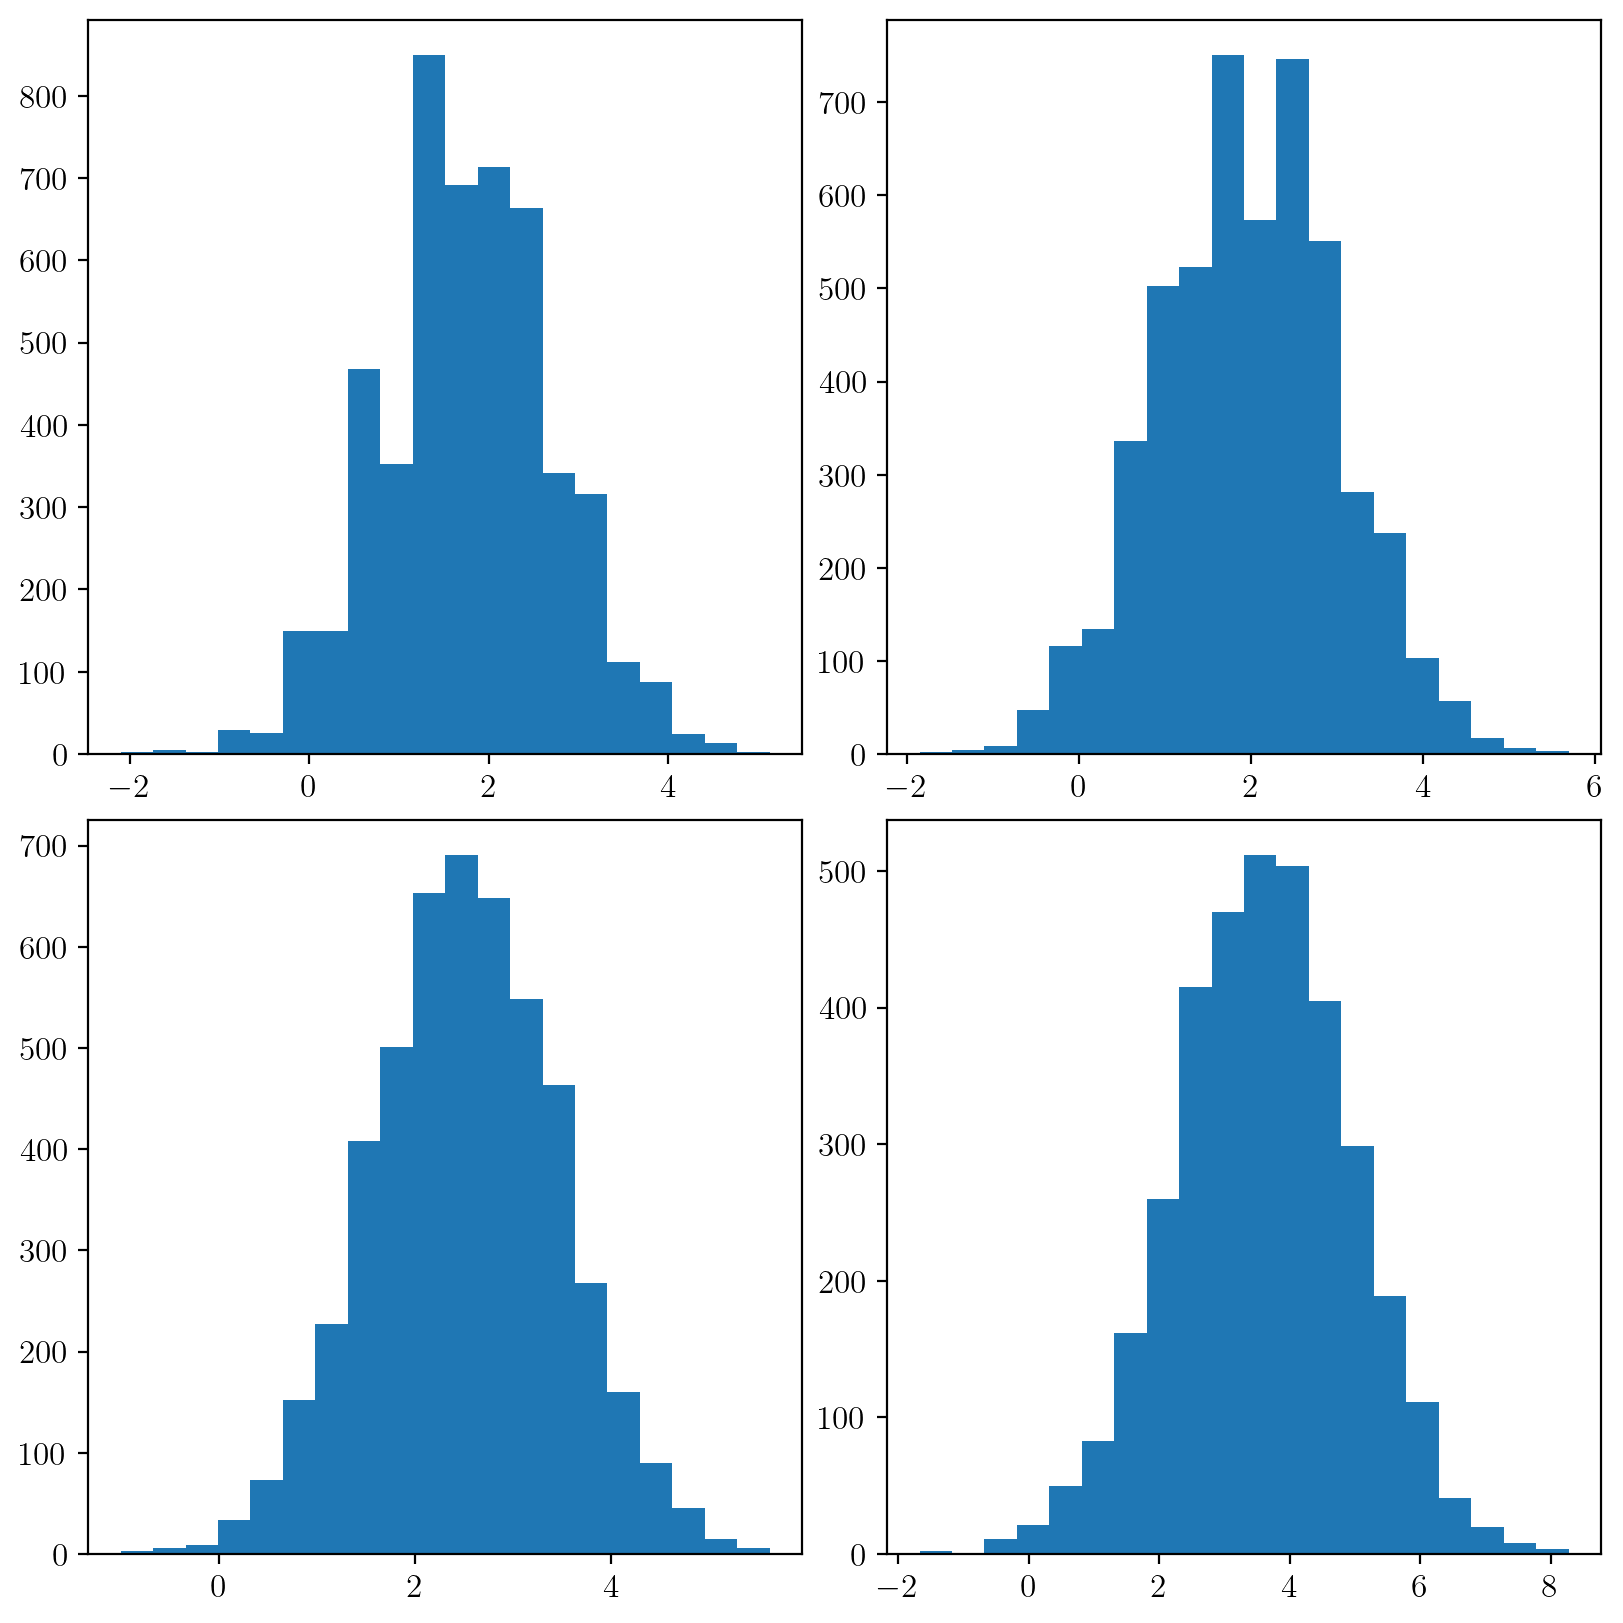

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8), constrained_layout=True)
plt.subplot(2, 2, 1)
plt.hist(results["zTNBC_stage1"], bins=20)
plt.subplot(2, 2, 2)
plt.hist(results["zTNBC_stage2"], bins=20)
plt.subplot(2, 2, 3)
plt.hist(results["zfull_stage1"], bins=20)
plt.subplot(2, 2, 4)
plt.hist(results["zfull_stage2"].replace(-np.inf, np.nan).dropna(), bins=20)
plt.show()

In [ ]:
# STOP HERE! THe below is just random scratch code, which might be useful later

In [ ]:
grid = ip.cartesian_grid(
    [-1, 1],
    [-1, 1],
    n=[20, 20],
    prune=True,
    null_hypos=[
        ip.hypo("theta0 < " + str(logit(0.3))),
        ip.hypo("theta1 <" + str(logit(0.3))),
    ],
)
# x=BinomialClosed(0, 2, n = [100,100])
# outs = x.sim_batch(0, 2, theta = grid.get_theta(), null_truth=grid.df[["null_truth0", "null_truth1", "null_truth2"]])

In [ ]:
class BinomialClosed:
    def __init__(self, seed, max_K, *, n):
        self.family = "binomial"
        self.family_params = {"n": n[0]}
        self.n = n
        key = jax.random.PRNGKey(seed)
        splitkeys = jax.random.split(key, num=2)
        self.samples_arm1 = jax.random.uniform(
            splitkeys[1], shape=(max_K, n[1]), dtype=np.float32
        )

        self.samples_arm0 = jax.random.uniform(
            splitkeys[0], shape=(max_K, n[0]), dtype=np.float32
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        p = expit(theta)
        # successes is a 2-dimensional array of shape: (n_tiles, n_sims = K)
        successes1 = np.sum(
            self.samples_arm1[None, begin_sim:end_sim, :] < p[:, None, None, 1], axis=2
        )
        successes0 = np.sum(
            self.samples_arm0[None, begin_sim:end_sim, :] < p[:, None, None, 0], axis=2
        )
        phat1 = successes1 / self.n[1]
        phat0 = successes0 / self.n[0]
        # pooledphat = (phat1*self.n[1] + phat0*self.n[0]) / (self.n[1] + self.n[0])
        zstat0 = (phat0 - 0.5) / np.sqrt(phat0 * (1 - phat0) / self.n[0])
        zstat1 = (phat1 - 0.7) / np.sqrt(phat1 * (1 - phat1) / self.n[1])
        zstatcombo = (0.4 * (phat0 - 0.5) + 0.6 * (phat1 - 0.7)) / np.sqrt(
            0.4**2 * phat0 * (1 - phat0) / self.n[0]
            + 0.6**2 * phat1 * (1 - phat1) / self.n[1]
        )
        pvalues = 1 - scipy.stats.norm.cdf([zstat0, zstat1, zstatcombo])
        pvalues = np.nan_to_num(pvalues) + (
            [phat0, phat1, phat1 * phat0] == np.full_like(pvalues, 0)
        )
        # The following needs to be vectorized
        possible_critical_values = np.sort(
            np.concatenate(
                (
                    pvalues,
                    2 * pvalues,
                    3 * pvalues,
                    np.full_like(pvalues[1, :, :], 100)[None, :, :],
                )
            ),
            axis=0,
        )
        # next we need to apply closed testing to the 3 pvalues for EVERY choice in the list of possible critical values
        rejections_list = closed_test_full(pvalues, possible_critical_values)
        nullstatus = np.asarray(np.transpose(null_truth))
        falserejs = np.logical_and(rejections_list, nullstatus[None, :, :, None])
        fwer = np.any(falserejs, axis=1)
        # some akwardness to cause the following minimum to give us the right answer
        temp = 1000 * (1 - fwer) + fwer * possible_critical_values
        out = np.min(temp, axis=0)
        # out.shape : n_tiles, n_sims
        return out

In [4]:
# Make sure to grid -lambda space!
grid = ip.cartesian_grid(
    [-2.0, -1.0],
    [-2.0, -1.0],
    n=[20, 20],
    prune=True,
    null_hypos=[ip.hypo("theta0 < theta1")],
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=400, worker_id=1, t=1674863641, n_bits=18, worker_bits=18) = [4415288571414708224 4415288571414708225 4415288571414708226, ...]:


In [72]:
# @jax.vmap
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    n0 = jnp.array([jnp.sum(~group), jnp.sum(group)])
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = n0[:, None] - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    return jnp.sum(Oij[0] - Eij[0], axis=0) / jnp.sqrt(denom)

In [ ]:
# writing pseudocode for Wassmer and Dragalin (2015)
# Let's do example 4.3 but applied to the subgroups of 4.1
# Calculate worst-possible lengths: max sample size is 300; 54% HRplus / 46% split
# Control rates are assumed to be: 0.34 HRplus, 0.23 otherwise.
# We can enforce this for now, will grid it out later

# (1) Generate max-samples in 4 columns: [HRplus T, HRplus C, HR+ T, HT+ C]
# (2) Check effect size after first 150 patients; if difference > 0.1, drop the loser
# (3) Do a z-combination test of the log-rank stats from the two time-points
# (4) do closed testing if both groups are live. alpha = 0.025
# (5) the intersection test

# start the above with validation on treatment effects grid
# then do it validating over

In [130]:
totalpatients = 600
# Groups list:
# 1: !HRplus ^ PH-; 2: HRplus ^ PH+; 3: !HRplus ^ PH+; 4: HRplus ^ PH-
# The 4 groups to analyze are:
# F = All groups, 1+2+3+4
# S1: HRplus = 2 + 4
# S2: PHS = 2 + 3
# S3: HRplus + PHS = 2
popfractions = [0.24, 0.3, 0.36, 0.10]
samplesizes = totalpatients * np.array(popfractions)
# These will have to be halved for treatment and control later!
np.repeat(samplesizes, 2) / 2  # input sample sizes!
# subgroup 0: all groups

array([ 72.,  72.,  90.,  90., 108., 108.,  30.,  30.])

#Steps of the design:

\begin{itemize}
\item Determine the nullspace:
In this case, we're going to analyze
closed testing's Type I Error separately for each intersection hypothesis. For conservatism, we'll assume the alternative guy trips the test, and is retained in the design to increase variability, but also does not eliminate any of the other arms (?)
...oh no I think this doesn't work! Backing up!!!
\item
Simulate exponentials
Determine the interim analysis time: first 150 events
Perform the log-rank test on that subset of events
Use the epsilon-selection to select arms:
0.667 > (control events / treat events)\_best - (control events / treat events)
Eliminate hypotheses completely for dropped arms
Determine the final analysis time: first 151-300 events
Determine the final analysis time: 300 events

Normal combination test (sqrt(2)) factor
\end{itemize}


list

In [88]:
maxN = [
    int(HRplus_selected_final_samps[0]),
    HRplus_selected_final_samps[1],
    HER_selected_final_samps[2],
    HER_selected_final_samps[3],
]

In [114]:
import scipy.stats

rvs = scipy.stats.expon.rvs(size=(maxN[0], 6))
hazard_ratio = 1
control_HRplus = rvs[:, 0]
control_HER = rvs[:, 1]
control_group3 = rvs[:, 2]
treat_HRplus = rvs[:, 1] / hazard_ratio
treat_HER = rvs[:, 3] / hazard_ratio

In [115]:
def logrank_2group(control, treatment):
    outcomes = np.concatenate([control, treatment])
    group = np.concatenate(
        [np.zeros(control.shape[0]), np.ones(treatment.shape[0])]
    ).astype(bool)
    ours = logrank_test(outcomes, group, censoring_time=10000)
    return ours

In [116]:
output = logrank_2group(control_HRplus, treat_HRplus)

In [117]:
output

DeviceArray(1.5558844, dtype=float32)

In [24]:
class LogRankVlad:
    def __init__(self, seed, max_K, *, n, censoring_time):
        self.max_K = max_K
        self.censoring_time = censoring_time
        self.n = n
        self.family = "exponential"
        self.family_params = {"n": n}

        self.key = jax.random.PRNGKey(seed)
        self.samples_1 = jax.random.exponential(self.key, shape=(max_K, n, 4))
        self.group = jnp.concatenate(
            [jnp.zeros((max_K, n)), jnp.ones((max_K, n))], axis=1
        ).astype(bool)
        self.vmap_logrank_test = jax.vmap(
            jax.vmap(logrank_test, in_axes=(0, 0, None)), in_axes=(0, None, None)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control_hazard = -theta[:, 0]
        treatment_hazard = -theta[:, 1]
        hazard_ratio = treatment_hazard / control_hazard
        control_rvs = jnp.tile(
            self.samples[None, :, :, 0], (hazard_ratio.shape[0], 1, 1)
        )
        treatment_rvs = self.samples[None, :, :, 1] / hazard_ratio[:, None, None]
        all_rvs = jnp.concatenate([control_rvs, treatment_rvs], axis=2)
        test_stat = -self.vmap_logrank_test(all_rvs, self.group, self.censoring_time)
        return test_stat

DeviceArray([          nan, 5.2642647e-02,           nan, 5.2622620e-02,           nan,
                       nan,           nan,           nan, 5.2641593e-02, 2.2225672e-01, ...,
                       nan, 5.2633159e-02,           nan, 5.2621566e-02,           nan,
                       nan, 2.8201441e-09,           nan,           nan,           nan],            dtype=float32)

In [ ]:
g = ip.cartesian_grid(
    [-1, -1], [-1, -1], n=[1, 1], null_hypos=[ip.hypo("theta0 > theta1")]
)

In [ ]:
lr = LogRank(0, 200000, n=100, censoring_time=10000000)
stats = lr.sim_batch(0, lr.max_K, g.get_theta(), g.get_null_truth())